# Importing required libraries, driver and selenium configuration

In [2]:
# IMPORT OF REQUIRED LIBRARIES

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from time import sleep
import pandas as pd
from selenium.webdriver.common.by import By


# PART 1 & 2 - Fetching website content and scraping the site for all data




In [3]:
# FETCHING THE WEBSITE CONTENT
service = ChromeService(r"C:\Users\barbo\Documents\CodersLab_Course_Python_Data_Analysis\Web_scraping\Webscraping_and_plots_-_Exercise_files\03_Web scraping\chromedriver.exe")
browser = webdriver.Chrome(service=service)

url = "https://www.scrapethissite.com/pages/forms/?page_num=1"
browser.implicitly_wait(15)
browser.get(url)

# TARGETING THE TABLE where the necessary data are stored, accessing headers expressions
table = browser.find_element("class name", "table")
headers = table.find_elements("tag name", "th") #generates a list with headers surrounded characters

# CREATING A LIST OF HEADER EXPRESSIONS only, without the strange characters
header_list = []
for i in headers:
    header_list.append(i.text.strip())

# CREATING an EMPTY DATAFRAME and INSERTING THE HEADERS = names of the columns
df_raw = pd.DataFrame(columns=header_list)

# LOOP that extracts the table data until it accesses the last page
while True:
    # I need to rewrite the table variable every time a new page is loaded
    table = browser.find_element("class name", "table")
    
    # Extracting rows 1 by 1 (the 1st row = headers I am skipping as it is already in the empty DF I have created earlier '1:')
    rows = table.find_elements("tag name", "tr")[1:]
    for row in rows:
        columns = row.find_elements("tag name", "td") # creates list of ["Boston Bruins","1990", "44", "24", "", "0.5", "299", "264", "35"] with wierd characters
        point_data = [col.text.strip() for col in columns] # without the wierd characters
  
        # Inserting the extracted row into the empty dataframe
        df_raw.loc[len(df_raw)] = point_data

    # At this point I have extracted all the data from the current page and I am clicking on the next page
    try:
        next_button = browser.find_element(By.XPATH, "//a[@aria-label='Next']")
        next_button.click()
        sleep(6)
        table = browser.find_element("class name", "table")
    except:
        break # eliminates the case when the website goes to the last page and there is no "Next" button any more

df_raw
browser.quit()

In [ ]:
# TRANSFORM ALL EXTRACTED RAW DATA to JSON FORMAT

import json

# DATA FRAME to DITIONARY
raw_data = df_raw.to_dict(orient="list")
        
# DICTIONARY TO JSON
with open (r"C:\Users\barbo\Documents\CodersLab_Course_Python_Data_Analysis\Workshop_-_files\data\raw\hockey_teams_raw", "w") as file:
    file.write(json.dumps(raw_data))

# PART 3 - EXPLORATORY ANALYSIS

In [4]:
# RENAMING THE COLUMNS IN DF

new_headers = {
    "Team Name":"team", 
    "Year": "season", 
    "Wins": "victories",
    "Losses": "defeats",
    "OT Losses": "overtime_defeats",
    "Win %": "victory_percentage",
    "Goals For (GF)": "scored_goals",
    "Goals Against (GA)": "received_goals",
    "+ / -": "goal_difference"
    }
df = df_raw.rename(columns=new_headers)
df.head()

,team,season,victories,defeats,overtime_defeats,victory_percentage,scored_goals,received_goals,goal_difference
0,Boston Bruins,1990,44,24,,0.55,299,264,35
1,Buffalo Sabres,1990,31,30,,0.388,292,278,14
2,Calgary Flames,1990,46,26,,0.575,344,263,81
3,Chicago Blackhawks,1990,49,23,,0.613,284,211,73
4,Detroit Red Wings,1990,34,38,,0.425,273,298,-25


In [ ]:
# REMOVING EMPTY VALUES

# df["overtime_defeats"].unique() #array(['', '3', '4', '6', '5', '0', '2', '1', '8', '7', '9', '12', '16', '11', '13', '14', '15', '10', '18'], dtype=object)
# df["overtime_defeats"].value_counts()[""] # empty value appears 224 x
df["overtime_defeats"] = df["overtime_defeats"].replace("", "0")
df["overtime_defeats"].value_counts()["0"] # "0" value appears 226 x, why is there the difference?

np.int64(226)

In [ ]:
# CONVERTING overtime_defeats COLUMN TO INT TYPE DATA
df["overtime_defeats"] = pd.to_numeric(df["overtime_defeats"], errors='coerce')
#df.info()

try:
    df["overtime_defeats"].value_counts()["NaN"] # Are there any replacements with "NaN"?
except:
    pass


In [ ]:
# CHECKING THE UNIQUE VALUES IN EACH COLUMN - THIS WAY EMPTY VALUES CAN BE DISPLAYED

# df["victories"].unique()
# df["defeats"].unique()
# df["victory_percentage"].unique()
# df["scored_goals"].unique()
# df["received_goals"].unique()
# df["goal_difference"].unique()
df["season"].unique() # season 2004 is missing

array(['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011'], dtype=object)

Season 2004 is missing.

DATASET ANALYSIS

In [41]:
#df["overtime_defeats"].unique() # array([ 0,  3,  4,  6,  5,  2,  1,  8,  7,  9, 12, 16, 11, 13, 14, 15, 10, 18])
teams_participated = df["team"].nunique() # returns the number of unique values of the column "team" = 35
seasons_available = df["season"].nunique() # returns the number of seasons = 21
time_span = int(df["season"].max()) - int(df["season"].min())
print(f"The number of teams that participated: {teams_participated}.\nWe have data available through {seasons_available} seasons.\nThe time span of the data available is across {time_span} years.")

The number of teams that participated: 35.
We have data available through 21 seasons.
The time span of the data available is across 21 years.


In [ ]:
# CONVERTING THE OTHER COLUMNS TO NUMERIC TYPE SO THAT WE CAN CARRY OUT CALCULATIONS

columns_to_convert = df.iloc[:, 2:] 
for i in columns_to_convert:
    df[i] = pd.to_numeric(df[i], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 582 entries, 0 to 581
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   team                582 non-null    object 
 1   season              582 non-null    object 
 2   victories           582 non-null    int64  
 3   defeats             582 non-null    int64  
 4   overtime_defeats    582 non-null    int64  
 5   victory_percentage  582 non-null    float64
 6   scored_goals        582 non-null    int64  
 7   received_goals      582 non-null    int64  
 8   goal_difference     582 non-null    int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 45.5+ KB


In [ ]:
# CHECKINF FOR OUTLIERS in numeric columns

columns_to_check = ["victories", "defeats", "overtime_defeats", "victory_percentage", "scored_goals", "received_goals", "goal_difference"]

for c in columns_to_check:
    Q1 = df[c].quantile(0.25)
    Q3 = df[c].quantile(0.75)
    IQR= Q3 - Q1 # inter-quartile range

    outlier_count = 0
    outliers = []
    
    for i in range(len(df)):
        value = df[c].iloc[i]

        # Define outliers
        if value < (Q1 - 1.5 * IQR) or value > (Q3 + 1.5 * IQR):
            outlier_count += 1
            clean_value = str(value).replace("np.int64()","").replace("np.float64()","")
            outliers.append(clean_value)
        
    try:
            print(f"In column '{c}' there are {outlier_count} outliers: {outliers}.") # Are there any outliers?
    except:
        break

In column 'victories' there are 4 outliers: ['10', '11', '9', '62'].
In column 'defeats' there are 11 outliers: ['58', '70', '71', '54', '61', '11', '59', '55', '55', '54', '57'].
In column 'overtime_defeats' there are 0 outliers: [].
In column 'victory_percentage' there are 5 outliers: ['0.119', '0.131', '0.167', '0.756', '0.171'].
In column 'scored_goals' there are 40 outliers: ['344', '340', '342', '320', '321', '343', '330', '332', '335', '322', '369', '338', '326', '335', '319', '367', '351', '346', '325', '322', '356', '125', '130', '136', '136', '115', '127', '142', '125', '136', '126', '139', '117', '129', '120', '135', '136', '326', '325', '362'].
In column 'received_goals' there are 17 outliers: ['354', '359', '337', '369', '340', '395', '414', '397', '344', '127', '119', '115', '117', '127', '121', '120', '357'].
In column 'goal_difference' there are 8 outliers: ['-118', '-140', '-193', '-196', '-196', '144', '-118', '-143'].


In [ ]:
# Getting statistical data for individual teams

import numpy as np

df_by_team = df.groupby("team")

for c in columns_to_check:
    result = df_by_team[c].agg([
        ("count", "count"),
        ("mean", "mean"),
        ("std", "std"),
        ("25th_percentile", lambda x: np.percentile(x, 25)),
        ("50th_percentile", lambda x: np.percentile(x, 50)),
        ("75th_percentile", lambda x: np.percentile(x, 75))
    ])
    print(f"Statistics by '{c}':\n{result}\n")

Statistics by 'victories':
                         count       mean        std  25th_percentile  \
team                                                                    
Anaheim Ducks                6  42.833333   5.564770            39.75   
Atlanta Thrashers           11  31.090909   8.915767            27.00   
Boston Bruins               21  38.857143   7.837638            36.00   
Buffalo Sabres              21  38.238095   7.489358            35.00   
Calgary Flames              21  36.380952   7.214404            31.00   
Carolina Hurricanes         14  36.785714   7.329378            33.25   
Chicago Blackhawks          21  36.428571   8.834995            30.00   
Colorado Avalanche          16  42.312500   5.498106            40.75   
Columbus Blue Jackets       11  31.090909   5.224070            28.50   
Dallas Stars                18  41.777778   9.045997            38.00   
Detroit Red Wings           21  46.952381   6.859127            44.00   
Edmonton Oilers         

TEAMS

In [ ]:
# TEAMS PARTICIPATING IN ALL SEASONS

total_seasons = len(df['season'].unique())

#team_in_seasons = (df_by_team.size()) #does not return rows * columns number as usual but due to grouped DF it only returns number of seasons each team participated

teams_in_all_seasons = (
    df_by_team["season"].nunique()
    .loc[lambda x: x == total_seasons] #.loc[...] is used to access rows by label or apply boolean filtering. When you pass a lambda function to .loc, it applies the lambda to the entire object (in this case, the Series x) and returns only the rows where the condition is True.
    .index.tolist()                    # .index function returns 'index labels' which are in this case the team'names. This is still a special Pandas object, not a plain Python list, that s why we convert it tolist()
)

print(f"There are {len(teams_in_all_seasons)} teams in all seasons:", teams_in_all_seasons)

There are 17 teams in all seasons: ['Boston Bruins', 'Buffalo Sabres', 'Calgary Flames', 'Chicago Blackhawks', 'Detroit Red Wings', 'Edmonton Oilers', 'Los Angeles Kings', 'Montreal Canadiens', 'New Jersey Devils', 'New York Islanders', 'New York Rangers', 'Philadelphia Flyers', 'Pittsburgh Penguins', 'St. Louis Blues', 'Toronto Maple Leafs', 'Vancouver Canucks', 'Washington Capitals']


In [87]:
# BEST 5 PERFORMING TEAMS IN LEAGUE HISTORY

avg_victory_percentage = df.groupby(["team", "season"])["victory_percentage"].agg("mean").sort_values(ascending=False)
avg_victory_percentage.head(8)


team                 season
Detroit Red Wings    1995      0.756
                     2005      0.707
                     1994      0.688
Pittsburgh Penguins  1992      0.667
Vancouver Canucks    2010      0.659
Detroit Red Wings    2007      0.659
Washington Capitals  2009      0.659
Buffalo Sabres       2006      0.646
Name: victory_percentage, dtype: float64

In [ ]:
# TEAMS THAT NEVER WON ANY SEASON IN LEAGUE HISTORY

winners = (
    df
    .sort_values(by=["season", "victories"], ascending=False)
    .groupby(by=["season"])
    .head(1) # in season 2011 New yort rangers share the 1st spot with Pittsburgh Penguins and Vencouver Canucks. In season 2008 boston bruins share the 1st place with san jose sharks.
    .groupby(by="team")
    .size()
)

winners.head(50)
losers = set(df["team"].unique()).difference(set(winners.index)) #df['team'].unique()...return a list, set function converts the list into a set, the set type is required to be able to call the difference function. set(...).difference(set(...)) returns all elements that are in the first set (all teams) but not in the second set (winning teams).
losers # this solution included San Jose Sharks in loser list although they scored the same as Boston Bruins in 2008

{'Anaheim Ducks',
 'Atlanta Thrashers',
 'Calgary Flames',
 'Carolina Hurricanes',
 'Columbus Blue Jackets',
 'Edmonton Oilers',
 'Florida Panthers',
 'Hartford Whalers',
 'Los Angeles Kings',
 'Mighty Ducks of Anaheim',
 'Minnesota North Stars',
 'Minnesota Wild',
 'Montreal Canadiens',
 'Nashville Predators',
 'New Jersey Devils',
 'New York Islanders',
 'Philadelphia Flyers',
 'Phoenix Coyotes',
 'Quebec Nordiques',
 'San Jose Sharks',
 'Tampa Bay Lightning',
 'Toronto Maple Leafs',
 'Winnipeg Jets'}

OVERTIME DEFEATS

In [ ]:
# TEAMS WITH THE MOST OVERIME DEFEATS

overtime_df = df.loc[df["overtime_defeats"] != 0] # targeting for teams that lost in overtime
variable = (overtime_df
            .sort_values("overtime_defeats", ascending=False)
            .groupby(["team","season"])
)
#variable.head(20) # highest number of overtime defeats is 18
teams_with_highest_OD = df.loc[df["overtime_defeats"] == 18]
teams = teams_with_highest_OD["team"].unique().tolist()
print(f"The teams with the most overtime defeats are: {teams}.")

The teams with the most overtime defeats are: ['Tampa Bay Lightning', 'Florida Panthers'].


In [ ]:
# RANKING THE TEAMS WITH MOST OVERTIME DEFEATS

# Filtering out teams with 0 overtime defeats and grouping by teams and season
overtime_df = df[df["overtime_defeats"] != 0]
grouped = overtime_df.groupby(["team", "season"])["overtime_defeats"].sum().reset_index() # the sum function adds multiple rows per team/season together, reset_index() function is necessary if we want to add a column, it makes the grouped data a normal DataFrame to work with later

# Adding a rank column to the grouped DF
grouped["rank"] = grouped["overtime_defeats"].rank(method="dense", ascending=False) # rank() function gives 1 to the team with the highest total, 2 to the next highest, etc., with no gaps

# Sorting DF by rank
ranked = grouped.sort_values("rank")

print(ranked.head(10))  # top 10 ranked by overtime defeats

                      team season  overtime_defeats  rank
315    Tampa Bay Lightning   2008                18   1.0
146       Florida Panthers   2011                18   1.0
52          Calgary Flames   2011                16   2.0
22           Boston Bruins   2005                16   2.0
141       Florida Panthers   2006                16   2.0
187     Montreal Canadiens   2011                16   2.0
63     Carolina Hurricanes   2011                16   2.0
300        St. Louis Blues   2005                15   3.0
158      Los Angeles Kings   2011                15   3.0
96   Columbus Blue Jackets   2009                15   3.0


In [163]:
# % OF TEAMS THAT LOST AT LEAST ONCE IN OVERTIME

lost_in_overtime = df[df["overtime_defeats"] != 0]["team"].unique().size
all_teams = df["team"].unique().size
percentage = round(((lost_in_overtime/all_teams)*100),2)
print(f"{percentage} % of teams lost in overtime at least once.")

91.43 % of teams lost in overtime at least once.


In [164]:
# SEASON WITH THE HIGHEST NUMBER OF GAMES DECIDED IN OVERTIME
max_OD_games = df.loc[df["overtime_defeats"] == 18]
seasons_with_max_OD_games = max_OD_games["season"].unique().tolist()
print(f"The seasons with the most games decided in overtime are: {seasons_with_max_OD_games}.")

The seasons with the most games decided in overtime are: ['2008', '2011'].


GOALS_RATIO

In [173]:
# Creating a new column 'goals_ratio'
df["goals_ratio"] = df["scored_goals"]/df["received_goals"]
df["goals_ratio"].describe() # returns statistics


count    582.000000
mean       1.019061
std        0.187878
min        0.506297
25%        0.884685
50%        1.015705
75%        1.139585
max        1.795580
Name: goals_ratio, dtype: float64

In [ ]:
# Finding outliers in the 'goals_ratio'column

Q1 = df["goals_ratio"].quantile(0.25)
Q3 = df["goals_ratio"].quantile(0.75)
IQR= Q3 - Q1 # inter-quartile range

outlier_count = 0
outliers = []
    
for i in range(len(df)):
    value = df["goals_ratio"].iloc[i]

    # Define outliers
    if value < (Q1 - 1.5 * IQR) or value > (Q3 + 1.5 * IQR):
        outlier_count += 1
        clean_value = str(value).replace("np.float64()","")
        outliers.append(clean_value)
print(f"There are {outlier_count} outliers in 'goals_ratio' column.")
print(outliers)

There are 2 outliers in 'goals_ratio' column.
['1.5384615384615385', '1.7955801104972375']


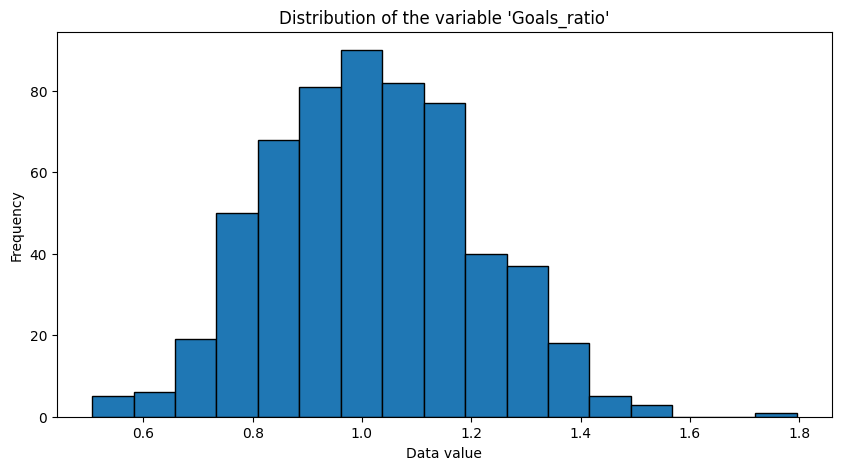

In [ ]:
# GENERATING A HISTOGRAM USING RICE'S RULE BINNING

import matplotlib.pyplot as plt
import math

bins = math.ceil(2 * ((len(df)) ** (1/3))) #2 times cube root of n; math.ceil rounds the number up to the next integer, len(df) is getting the number of datapoints
                                        # bins in this case returns the number 17
plt.figure(figsize = (10,5))
plt.hist(df["goals_ratio"], bins, edgecolor='black')
plt.title("Distribution of the variable 'Goals_ratio'")
plt.xlabel("Data value")
plt.ylabel("Frequency")
plt.show()

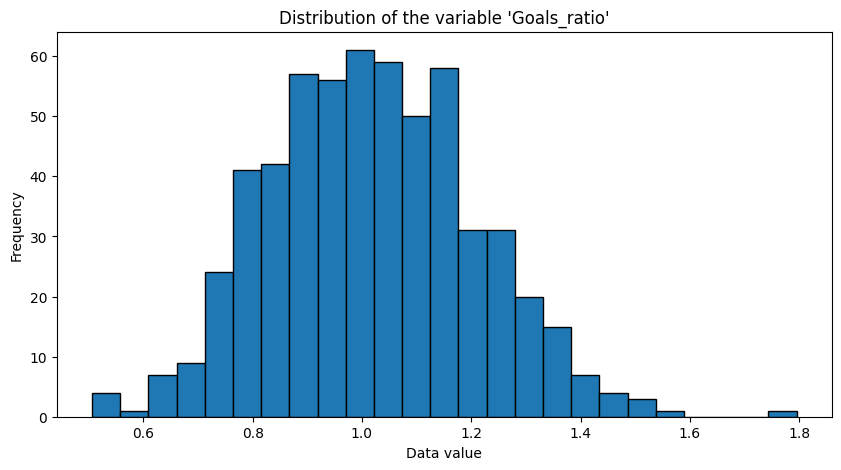

In [ ]:
# GENERATING A HISTOGRAM USING SQUARE ROOT RULE BINNING

bins2 = int((len(df)) ** (1/2)) + 1

plt.figure(figsize = (10,5))
plt.hist(df["goals_ratio"], bins2, edgecolor='black')
plt.title("Distribution of the variable 'Goals_ratio'")
plt.xlabel("Data value")
plt.ylabel("Frequency")
plt.show()

VICTORY_PERCENTAGE

In [199]:
# Statistics of the column 'victory_percentage'

df["victory_percentage"].describe() # returns statistics


count    582.000000
mean       0.458519
std        0.102237
min        0.119000
25%        0.390000
50%        0.463000
75%        0.534000
max        0.756000
Name: victory_percentage, dtype: float64

In [ ]:
# Finding outliers in the 'victory_percentage' column

Q1 = df["victory_percentage"].quantile(0.25)
Q3 = df["victory_percentage"].quantile(0.75)
IQR= Q3 - Q1 # inter-quartile range

outlier_count = 0
outliers = []
    
for i in range(len(df)):
    value = df["victory_percentage"].iloc[i]

    # Define outliers
    if value < (Q1 - 1.5 * IQR) or value > (Q3 + 1.5 * IQR):
        outlier_count += 1
        clean_value = str(value).replace("np.float64()","")
        outliers.append(clean_value)
print(f"There are {outlier_count} outliers in 'victory_percentage' column.")
print(outliers)

There are 5 outliers in 'victory_percentage' column.
['0.119', '0.131', '0.167', '0.756', '0.171']


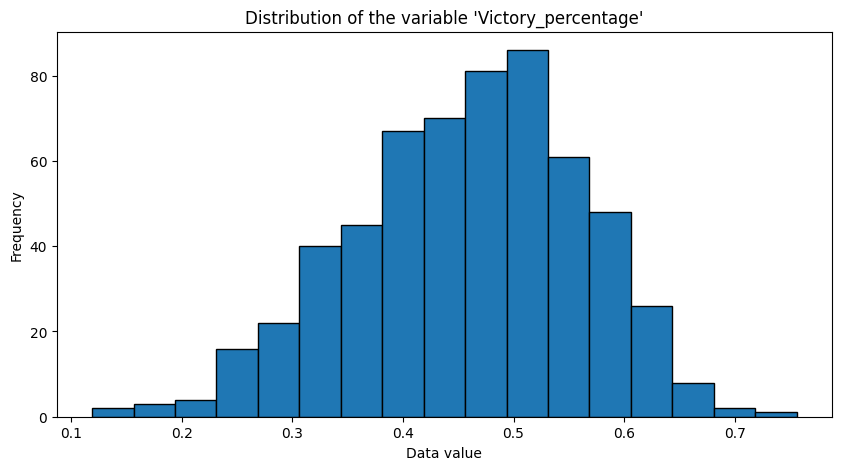

In [200]:
# Creating a histogram for the 'victory_percentage' column

plt.figure(figsize = (10,5))
plt.hist(df["victory_percentage"], 17, edgecolor='black')
plt.title("Distribution of the variable 'Victory_percentage'")
plt.xlabel("Data value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Finding the indeces of upper outliers in 'goals_ratio' column
Q1 = df["goals_ratio"].quantile(0.25)
Q3 = df["goals_ratio"].quantile(0.75)
IQR= Q3 - Q1 # inter-quartile range
for i in range(len(df)):
    value = df["goals_ratio"].iloc[i]

    # Define outliers
    if value < (Q1 - 1.5 * IQR) or value > (Q3 + 1.5 * IQR):
        clean_value = str(value).replace("np.float64()","")
        print(f"row number: {i}; value: {clean_value}")
    elif value < 0.5:
        clean_value = str(value).replace("np.float64()","")
        print(f"row number: {i}; value: {clean_value}")

row number: 99; value: 1.5384615384615385
row number: 126; value: 1.7955801104972375


In [216]:
# Filtering for outliers
# df.loc[df["goals_ratio"] < 0.6]
# df.loc[df["victory_percentage"] > 0.66]
df.loc[df["victory_percentage"] < 0.2]

,team,season,victories,defeats,overtime_defeats,victory_percentage,scored_goals,received_goals,goal_difference,goals_ratio
56,Ottawa Senators,1992,10,70,0,0.119,202,395,-193,0.511392
60,San Jose Sharks,1992,11,71,0,0.131,218,414,-196,0.526570
82,Ottawa Senators,1993,14,61,0,0.167,201,397,-196,0.506297
108,Ottawa Senators,1994,9,34,0,0.188,117,174,-57,0.672414
225,Atlanta Thrashers,1999,14,57,4,0.171,170,313,-143,0.543131


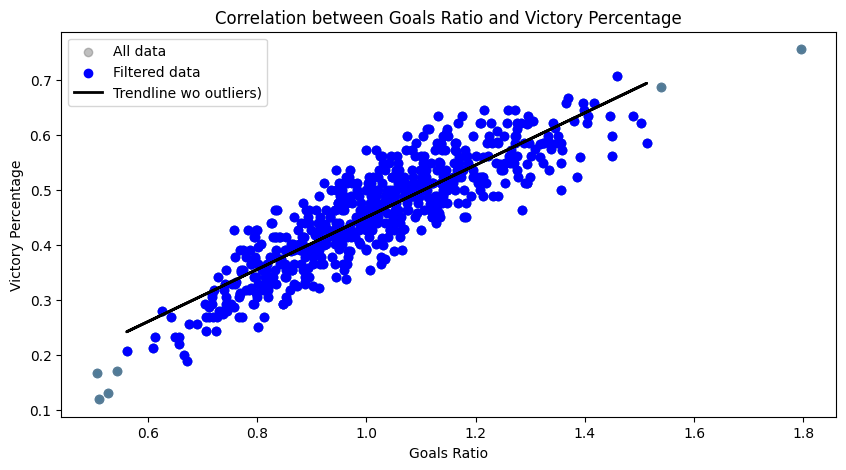

In [ ]:
# GENERATING A SCATTER PLOT FOR THE CORRELATION BETWEEN 'Goals_ratio' and 'Victory_percentage'
import numpy as np

plt.figure(figsize=(10,5))
plt.scatter(df["goals_ratio"], df["victory_percentage"])

# List of outlier row indices i want to exclude
outliers = [99, 126, 82, 56, 60, 225]

# Drop those rows
df_wo_outliers = df.drop(outliers)

# Now get x and y without outliers
x = df_wo_outliers["goals_ratio"]
y = df_wo_outliers["victory_percentage"]

# Fit and plot the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.scatter(df["goals_ratio"], df["victory_percentage"], c="gray", alpha=0.5, label="All data")
plt.scatter(x, y, c="blue", label="Filtered data")
plt.plot(x, p(x), color="black", linewidth=2, label="Trendline wo outliers")
plt.xlabel("Goals Ratio")
plt.ylabel("Victory Percentage")
plt.legend()
plt.title("Correlation between Goals Ratio and Victory Percentage")
plt.show()


OBSERVATIONS

1) There is a correlation between goals_ratio and victor_percentage.
2) Some outliers can be identified by visual inspection of the scatter plot but I calculated outliers for both columns separately as follows (see above):
     value < (Q1 - 1.5 * IQR) or value > (Q3 + 1.5 * IQR)
3) I cannot think of any particular reason that could have caused their outlying nature.

In [220]:
# SAVING THE PROCESSED DATA FRAME INTO A CSV FILE

df.to_csv(r"C:\Users\barbo\Documents\CodersLab_Course_Python_Data_Analysis\Workshop_-_files\data\processed\hockey_teams_processed.csv",
    sep = ';',
    encoding = 'utf-8',
    index = False
)

# PART 4 BUSINESS RECOMMENDATIONS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# loading processed data

df = pd.read_csv(r"C:\Users\barbo\Documents\CodersLab_Course_Python_Data_Analysis\Workshop_-_files\data\processed\hockey_teams_processed.csv",
    sep = ';',
    encoding = 'utf-8')

df.head()

,team,season,victories,defeats,overtime_defeats,victory_percentage,scored_goals,received_goals,goal_difference,goals_ratio
0,Boston Bruins,1990,44,24,0,0.550,299,264,35,1.132576
1,Buffalo Sabres,1990,31,30,0,0.388,292,278,14,1.050360
2,Calgary Flames,1990,46,26,0,0.575,344,263,81,1.307985
3,Chicago Blackhawks,1990,49,23,0,0.613,284,211,73,1.345972
4,Detroit Red Wings,1990,34,38,0,0.425,273,298,-25,0.916107


In [7]:
# PROBABILITY OF ANY TEAM WINNING

glob_probability = df["victories"].sum()/((df["victories"] + df["defeats"]).sum())
glob_probability

np.float64(0.5331134859041432)

In [14]:
# DEFINING THE get_betting_odds function

def get_betting_odds(probability):
    odds = 1/probability
    return odds

In [15]:
# CALCULATING THE GLOBAL RATE USING THE get_betting_odds FUNCTION

glob_rate = round((get_betting_odds(glob_probability)),2)
print(f"The global rate is: {glob_rate}")


The global rate is: 1.88


In [ ]:
# CALCULATING THE PROBABILITIES OF WINNING AND LOOSING FOR EACH TEAM

df_by_team = df.groupby("team").agg({"victories": "sum", "defeats": "sum"})
df_by_team = df_by_team.apply(lambda x: x / x.sum(), axis = 1)
#df_by_team["victories"].sort_values(ascending=False)


team
Detroit Red Wings          0.672578
New Jersey Devils          0.616065
Dallas Stars               0.606941
Colorado Avalanche         0.594381
Anaheim Ducks              0.590805
Philadelphia Flyers        0.582985
Boston Bruins              0.570629
Pittsburgh Penguins        0.566509
St. Louis Blues            0.564370
Vancouver Canucks          0.559369
Buffalo Sabres             0.553411
Washington Capitals        0.549046
Nashville Predators        0.542611
Montreal Canadiens         0.540000
New York Rangers           0.538776
Chicago Blackhawks         0.531250
Calgary Flames             0.530924
Minnesota Wild             0.528031
Phoenix Coyotes            0.527962
Carolina Hurricanes        0.527664
Toronto Maple Leafs        0.524624
San Jose Sharks            0.517588
Ottawa Senators            0.510526
Los Angeles Kings          0.508003
Florida Panthers           0.486418
Edmonton Oilers            0.477241
Mighty Ducks of Anaheim    0.471535
Quebec Nordiques       

In [24]:
# CREATING A FUNCTION TO SORT THE TEAMS BY PROBABILITY TO WIN

def assign_team_to_league(x):
    if x >= (df_by_team["victories"].quantile(0.95)):
        return "A"
    elif x >= (df_by_team["victories"].quantile(0.70)):
        return "B"
    elif x >= (df_by_team["victories"].quantile(0.20)):
        return "C"
    else:
        return "D"

In [25]:
# CREATING A NEW COLUMN WHICH STATES THE LEAGUE THE TEAM FALLS INTO

df_by_team['league'] = (
    df_by_team
    .apply(
        lambda x: assign_team_to_league(x['victories']),
        axis=1
    )
)
df_by_team

,victories,defeats,league
team,,,
Anaheim Ducks,0.590805,0.409195,B
Atlanta Thrashers,0.439024,0.560976,D
Boston Bruins,0.570629,0.429371,B
Buffalo Sabres,0.553411,0.446589,B
Calgary Flames,0.530924,0.469076,C
Carolina Hurricanes,0.527664,0.472336,C
Chicago Blackhawks,0.531250,0.468750,C
Colorado Avalanche,0.594381,0.405619,B
Columbus Blue Jackets,0.436782,0.563218,D


In [ ]:
# ADDING THE LEAGUE COLUMN TO THE ORIGINAL df BY JOINING THE 2 dfs

df = df.merge(
    df_by_team["league"],
    left_on="team",
    right_index=True
)
df.head()

,team,season,victories,defeats,overtime_defeats,victory_percentage,scored_goals,received_goals,goal_difference,goals_ratio,league
0,Boston Bruins,1990,44,24,0,0.550,299,264,35,1.132576,B
1,Buffalo Sabres,1990,31,30,0,0.388,292,278,14,1.050360,B
2,Calgary Flames,1990,46,26,0,0.575,344,263,81,1.307985,C
3,Chicago Blackhawks,1990,49,23,0,0.613,284,211,73,1.345972,C
4,Detroit Red Wings,1990,34,38,0,0.425,273,298,-25,0.916107,A


In [32]:
# Grouping the new df by league and calculating the probabilities to win in each league and then passing the values to the get_betting_odds function
df_by_league = (
    df
    .groupby("league")
    .agg({"victories": "sum", "defeats": "sum"})

     .apply(lambda x: x["victories"] / (x["victories"] + x["defeats"]), axis=1)
 )
df_by_league
df_by_league.apply(lambda x: get_betting_odds(x))

league
A    1.552089
B    1.741296
C    1.925992
D    2.275578
dtype: float64